# Sparkify Churn Prediction

Aim of this project is to predict users who churn from using the Sparkify music application. The first step involves extracting, cleaning and creating features (to be used for predicting churn). Plots of the features are then produced. A model is then fitted on the data and assessed. The primary metrics used to assess the performance of the model are the Gini and AUC measures.

### 1. Data Preparation

Extract, clean and create features using the data. The features are created by userId. The data is then rolled up by calendar date to get features for each user by day. This means that when the model is productionised, it gives a prediction for churning in that day given the features in the model for the specific user on that day. 

In [2]:
######################################## Import Libraries ########################################

import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import re

#################################### Create a Spark session and Read the data ####################################

spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

sparkify_data = 'mini_sparkify_event_data.json'

df = spark.read.json(sparkify_data)

df.createOrReplaceTempView("sparkify_data")

######################################## Clean the data ########################################

# There is no missing sessionId's, there are cases with missing userId 
# drop these cases as they don't relate to uses who use the music app

df_clean = spark.sql('''
          SELECT *
          FROM sparkify_data
          where userId <> "" or sessionId <> ""
          '''
          )
df_clean.createOrReplaceTempView("sparkify_data_c")

######################################## Create Date and Targets ########################################

base_data = spark.sql('''

              SELECT  *,
    
              ---format dates---
              from_unixtime(ts/1000,'YYYY-MM-dd') as date,
              month(from_unixtime(ts/1000,'YYYY-MM-dd')) as month,
              year(from_unixtime(ts/1000,'YYYY-MM-dd')) as year,
              day(from_unixtime(ts/1000,'YYYY-MM-dd')) as day,

                  case when page = 'Cancellation Confirmation' then 1
                  else 0 end as cancel,

                  case when page = 'Downgrade' then 1
                  else 0 end as downgrade

              FROM sparkify_data_c 
              
          '''
          )

base_data.createOrReplaceTempView("sparkify_base_data_c")


######################################## Feature Engineering ########################################

base_data2 = spark.sql('''
              SELECT *, 
              
              max(cancel) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as ever_cancel,
              
              sum(case when page = 'NextSong' then 1 else 0 end) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as cum_songs_played,
      
              sum(case when page = 'NextSong' then 1 else 0 end) over (
              partition by userId,date
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as cum_songs_played_by_date,
      
              sum(case when page = 'Add to Playlist' then 1 else 0 end) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as cum_songs_added_to_play_list,      
   
              sum(case when page = 'Logout' then 1 else 0 end) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as cum_logouts, 
   
              sum(case when page = 'Add Friend' then 1 else 0 end) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as cum_friends, 

              DATEDIFF(date,(min(date) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              )))+1 as days_as_user,
                         
            max(datediff(date,Lag(date, 1) OVER( partition by userId
            ORDER BY date ASC))) over (
              partition by userId
              order by ts
              ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
              ) as max_time_off
                            
              FROM sparkify_base_data_c     
          '''
          )
base_data2.createOrReplaceTempView("sparkify_base_data_c2")

###################### Summarise the data by Day and Create fields for modelling ######################

base_data_by_day = spark.sql('''

                select userId,date,max(ever_cancel) as ever_cancel,
                max(cancel) as cancel,
                max(downgrade) as downgrade,
                max(cum_songs_played) as cum_songs_played,
                max(cum_songs_played_by_date) as songs_played,
                max(cum_songs_added_to_play_list) as cum_songs_added_to_play_list,
                max(cum_logouts) as cum_logouts,
                max(cum_friends) as cum_friends,
                max(days_as_user) as days_as_user,
                max(max_time_off) as max_time_off,
                
                datediff(date,Lag(date, 1) OVER( partition by userId
                            ORDER BY date ASC)) as time_off,
                
                Lag(max(cum_songs_played_by_date),1) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p1,
   
                   Lag(max(cum_songs_played_by_date),2) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p2,
   
                   Lag(max(cum_songs_played_by_date),3) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p3,
                            
                    Lag(max(cum_songs_played_by_date),4) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p4,                   
   
                       Lag(max(cum_songs_played_by_date),5) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p5,
                            
                     Lag(max(cum_songs_played_by_date),6) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p6 ,
                            
                 Lag(max(cum_songs_played_by_date),7) OVER( partition by userId
                            ORDER BY date ASC) as songs_played_p7 
   
                from sparkify_base_data_c2
                
                group by userId,date

          '''
          )
base_data_by_day.createOrReplaceTempView("sparkify_base_data_by_day")

################### Create ratio of fields and data to be used for modelling - also full in missings ###################

base_data_by_day2 = spark.sql('''

                select userId,date,cancel,cancel as label,downgrade,case when time_off is null then 0 else time_off end as time_off,
                case when max_time_off is null then 0 else max_time_off end as max_time_off,
                case when cum_songs_played is null then 0 else cum_songs_played end as cum_songs_played,
                case when cum_songs_added_to_play_list is null then 0 else cum_songs_added_to_play_list end as cum_songs_added_to_play_list,
                case when cum_friends is null then 0 else cum_friends end as cum_friends,
                case when days_as_user is null then 0 else days_as_user end as days_as_user,
                
                case when songs_played_p1 is null then 1
                    else songs_played/songs_played_p1 end as curr_songs_to_prev_ratio,
                case when GREATEST(songs_played_p1,songs_played_p2,songs_played_p3,songs_played_p4,songs_played_p5,
                                    songs_played_p6,songs_played_p7) is null then 1 else songs_played/GREATEST(songs_played_p1,songs_played_p2,songs_played_p3,songs_played_p4,songs_played_p5,
                                    songs_played_p6,songs_played_p7) end as curr_songs_to_maxLw_ratio
                
                from sparkify_base_data_by_day

          '''
          )
base_data_by_day2.createOrReplaceTempView("sparkify_base_data_by_day2")


Description of Features created-

max_time_off: Maximum number of days a user didn't use the app for the period prior to the data date. 

cum_songs_played: Total number of songs played as at the data date.

cum_songs_added_to_play_list: Total number of songs added to a play list as at data date. 

cum_friends: Total friends added as at data date.

days_as_user: Number of days user has been present in the data. 

curr_songs_to_prev_ratio: Songs played current date vs previous day session.

curr_songs_to_maxLw_ratio: Current songs played against the maximum songs played in the previous 7 days active. 

### 1.1 Data Set Analysis 

Run some checks on the data.

In [3]:
## Count of Observations 

spark.sql('''
          SELECT COUNT(*) as count
          FROM sparkify_base_data_by_day2 
          '''
          ).show()

+-----+
|count|
+-----+
| 3124|
+-----+



In [4]:
## Count of Users

# Unique Users

spark.sql('''
            
            select count(*) as unique_users
            from
            (     
            select distinct userId
            from sparkify_base_data_by_day2
              )
          '''
          ).show(1)


+------------+
|unique_users|
+------------+
|         225|
+------------+



In [5]:
#### See what dates the data span ####

spark.sql('''
          SELECT distinct min(date),max(date)
          FROM sparkify_base_data_by_day2 
          '''
          ).show(1)

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



In [6]:
### Cancel and Downgrade rate

spark.sql('''
          SELECT avg(cancel) as cancel_rate, sum(cancel) as cancel_vol, avg(downgrade) as downgrade_rate, sum(downgrade) as downgrade_vol
          FROM sparkify_base_data_by_day2
          '''
          ).show()

+--------------------+----------+------------------+-------------+
|         cancel_rate|cancel_vol|    downgrade_rate|downgrade_vol|
+--------------------+----------+------------------+-------------+
|0.016645326504481434|        52|0.3325864276568502|         1039|
+--------------------+----------+------------------+-------------+



In [14]:
### Cancel and Downgrade rate

spark.sql('''
          SELECT avg(cancel) as cancel_rate, sum(cancel) as cancel_vol, count(*) as total_vol
          FROM sparkify_base_data_by_day2
          '''
          ).show()

+--------------------+----------+---------+
|         cancel_rate|cancel_vol|total_vol|
+--------------------+----------+---------+
|0.016645326504481434|        52|     3124|
+--------------------+----------+---------+



Discussion: The data is small with only 225 unique users in the mini dataset. It was suggested to model cancelations which occur on both paid and free users. There are only 52 cancleations in the data. This will make modelling tricky which such a small number of cancelations. The next section analyses the features against the cancelation rate to find promosing features. 

### 2. Feature Trend Analysis

Plot cancel rate and volume with the created features to gain in intital understanding of the data and which features might be the best for predicting churn. 

Text(0.5,1,'curr_songs_to_maxLw_ratio')

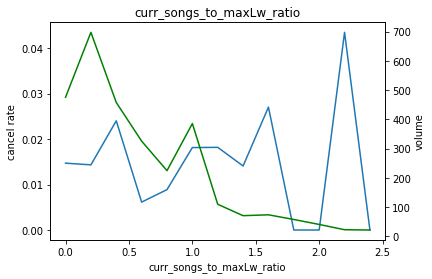

In [10]:
pdf = spark.sql('''
              SELECT round(curr_songs_to_maxLw_ratio/0.2,0)*0.2 as curr_songs_to_maxLw_ratio, 
                  avg(cancel) as cancel_rate, avg(downgrade) as downgrade_rate,
                  count(*) as vol
              FROM sparkify_base_data_by_day2
              group by round(curr_songs_to_maxLw_ratio/0.2,0)*0.2
              order by round(curr_songs_to_maxLw_ratio/0.2,0)*0.2
          '''
          ).toPandas()

pdf = pdf[pdf['curr_songs_to_maxLw_ratio']<2.5]
pdf = pdf.set_index('curr_songs_to_maxLw_ratio')
#pdf.plot()

plt.figure()
pdf.cancel_rate.plot()
plt.ylabel('cancel rate')
pdf.vol.plot(secondary_y=True, style='g')
plt.ylabel('volume')
plt.title('curr_songs_to_maxLw_ratio')

This field gives an indication of whether a user is increasing or decreasing usage. Below 1 means usage decreasing, and above 1 means usage increasing. There appears to be a weak trend with decreasing usage giving more chance of cancelation.

Text(0.5,1,'cum_songs_played')

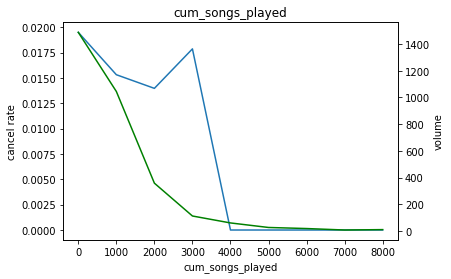

In [75]:
pdf = spark.sql('''
              SELECT round(cum_songs_played/1000,0)*1000 as cum_songs_played, 
                  avg(cancel) as cancel_rate, avg(downgrade) as downgrade_rate,
                  count(*) as vol
              FROM sparkify_base_data_by_day2
              group by round(cum_songs_played/1000,0)*1000
              order by round(cum_songs_played/1000,0)*1000
          '''
          ).toPandas()

pdf = pdf.set_index('cum_songs_played')
#pdf.plot()

plt.figure()
pdf.cancel_rate.plot()
plt.ylabel('cancel rate')
pdf.vol.plot(secondary_y=True, style='g')
plt.ylabel('volume')
plt.title('cum_songs_played')

This field possibly shows that the more songs played the less the chance of cancelation. 

Text(0.5,1,'cum_songs_added_to_play_list')

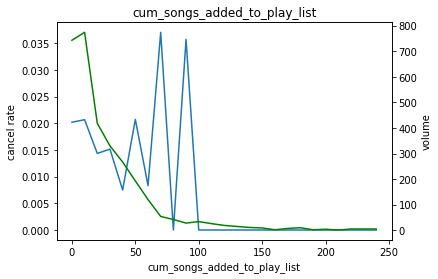

In [81]:
pdf = spark.sql('''
              SELECT round(cum_songs_added_to_play_list/10,0)*10 as cum_songs_added_to_play_list, 
                  avg(cancel) as cancel_rate, avg(downgrade) as downgrade_rate,
                  count(*) as vol
              FROM sparkify_base_data_by_day2
              group by round(cum_songs_added_to_play_list/10,0)*10
              order by round(cum_songs_added_to_play_list/10,0)*10
          '''
          ).toPandas()

pdf = pdf.set_index('cum_songs_added_to_play_list')
#pdf.plot()

plt.figure()
pdf.cancel_rate.plot()
plt.ylabel('cancel rate')
pdf.vol.plot(secondary_y=True, style='g')
plt.ylabel('volume')
plt.title('cum_songs_added_to_play_list')

This field potentially shows the more songs added to a play list the less the chance of cancelation. 

In [ ]:
max_time_off
days_as_user

Text(0.5,1,'days_as_user')

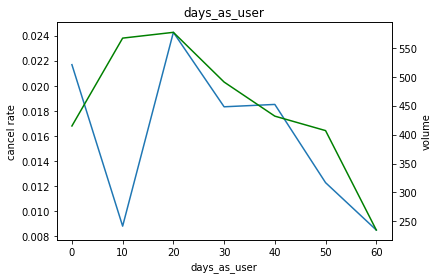

In [83]:
pdf = spark.sql('''
              SELECT round(days_as_user/10,0)*10 as days_as_user, 
                  avg(cancel) as cancel_rate, avg(downgrade) as downgrade_rate,
                  count(*) as vol
              FROM sparkify_base_data_by_day2
              group by round(days_as_user/10,0)*10
              order by round(days_as_user/10,0)*10
          '''
          ).toPandas()

pdf = pdf.set_index('days_as_user')
#pdf.plot()

plt.figure()
pdf.cancel_rate.plot()
plt.ylabel('cancel rate')
pdf.vol.plot(secondary_y=True, style='g')
plt.ylabel('volume')
plt.title('days_as_user')

Maybe a trend of longer days as user less chance of cancelation. 

Text(0.5,1,'max_time_off')

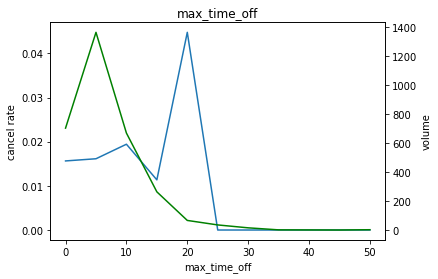

In [85]:
pdf = spark.sql('''
              SELECT round(max_time_off/5,0)*5 as max_time_off, 
                  avg(cancel) as cancel_rate, avg(downgrade) as downgrade_rate,
                  count(*) as vol
              FROM sparkify_base_data_by_day2
              group by round(max_time_off/5,0)*5
              order by round(max_time_off/5,0)*5
          '''
          ).toPandas()

pdf = pdf.set_index('max_time_off')

plt.figure()
pdf.cancel_rate.plot()
plt.ylabel('cancel rate')
pdf.vol.plot(secondary_y=True, style='g')
plt.ylabel('volume')
plt.title('max_time_off')

Greater - the time off, the less the cancelation rate - this doesn't seem to make much sense. This variable thus won't be used for the model. 

### 3. Variable Selection

Using logistic regression - determine which variables are the most important to be included in the model. This code selectes variables step by step - which variable is most predictive, then which variable is most predictive when added to the ones already added. 

The variable selection is done using both the traning and validation data - this is because the sample size is soo small. If the code is applied to the full data this can only be done on the training data - where the results should be more robust. 

In [7]:
##### Step 1. Determine 1st Variable for the Model - variable is selected as best distrminator on all the data

var_list = ["cum_songs_played","cum_songs_added_to_play_list","cum_friends","curr_songs_to_maxLw_ratio","curr_songs_to_prev_ratio","time_off","max_time_off","days_as_user"]

it1 = {}

for i in var_list:
    train, validation = base_data_by_day2.randomSplit([0.7, 0.3], seed=42)
    train.createOrReplaceTempView("train")
    validation.createOrReplaceTempView("validation")
    assembler = VectorAssembler(inputCols=[i],outputCol = "features",handleInvalid = "skip")
    pipeline = Pipeline(stages=[assembler])
    model = pipeline.fit(train)
    train = model.transform(train)
    lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0,featuresCol='features',labelCol = "cancel")
    lrModel = lr.fit(train)
    pred_train = lrModel.transform(train)
    validation = model.transform(validation)
    pred_val = lrModel.transform(validation)
    evaluator = BinaryClassificationEvaluator()
    it1[i] = [evaluator.evaluate(pred_train),evaluator.evaluate(pred_val)]
    # Prints the variable name and AUC on the training and validation data
    print(i,evaluator.evaluate(pred_train),evaluator.evaluate(pred_val))
    
df1 = pd.DataFrame(it1).T
df1[2] = 0.3*df1[1] + 0.7*df1[0]
df1 = df1.sort_values(by=[2])
df1 = df1.reset_index()
var1 = df1['index'].iloc[-1]

print('1st variable selected is',var1)


cum_songs_played 0.5620806137638843 0.45917776491024886
cum_songs_added_to_play_list 0.5550669872895913 0.49213472302644273
cum_friends 0.5657448757586166 0.42646207295888827
curr_songs_to_maxLw_ratio 0.5135322812051651 0.6161562318278732
curr_songs_to_prev_ratio 0.46615458473355753 0.4222178683385582
time_off 0.5115653269208749 0.41290291449527117
max_time_off 0.5394709721745103 0.3770507624010808
days_as_user 0.5679777854116569 0.39297432928006176
1st variable selected is curr_songs_to_maxLw_ratio


In [8]:
##### Step 2. Determine 2nd Variable for the Model - variable is selected as best distrminator on all the data

var_list = ["cum_songs_played","cum_songs_added_to_play_list","cum_friends","curr_songs_to_maxLw_ratio","curr_songs_to_prev_ratio","time_off","max_time_off","days_as_user"]

it2 = {}

for i in var_list:
    train, validation = base_data_by_day2.randomSplit([0.7, 0.3], seed=42)
    train.createOrReplaceTempView("train")
    validation.createOrReplaceTempView("validation")
    assembler = VectorAssembler(inputCols=[var1,i],outputCol = "features",handleInvalid = "skip")
    pipeline = Pipeline(stages=[assembler])
    model = pipeline.fit(train)
    train = model.transform(train)
    lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0,featuresCol='features',labelCol = "cancel")
    lrModel = lr.fit(train)
    pred_train = lrModel.transform(train)
    validation = model.transform(validation)
    pred_val = lrModel.transform(validation)
    evaluator = BinaryClassificationEvaluator()
    it2[i] = [evaluator.evaluate(pred_train),evaluator.evaluate(pred_val)]
    # Prints the variable name and AUC on the training and validation data
    print(i,evaluator.evaluate(pred_train),evaluator.evaluate(pred_val))
    
df2 = pd.DataFrame(it2).T
df2[2] = 0.3*df2[1] + 0.7*df2[0]
df2 = df2.sort_values(by=[2])
df2 = df2.reset_index()
df2 = df2[df2['index'] != var1]
var2 = df2['index'].iloc[-1]

print('Variables selected now are',var1,var2)


cum_songs_played 0.5686829268292684 0.49563868966854047
cum_songs_added_to_play_list 0.5632998565279771 0.5368288427989925
cum_friends 0.5693428981348637 0.4454351618530721
curr_songs_to_maxLw_ratio 0.5135322812051651 0.6161562318278732
curr_songs_to_prev_ratio 0.5105148531082049 0.59717868338558
time_off 0.5256987087517933 0.42033339794533764
max_time_off 0.5436671449067431 0.39746074820701693
days_as_user 0.5711276901004302 0.4097693351424694
Variables selected now are curr_songs_to_maxLw_ratio cum_songs_added_to_play_list


In [10]:
##### Step 3. Determine 3rd Variable for the Model - variable is selected as best distrminator on all the data

var_list = ["cum_songs_played","cum_songs_added_to_play_list","cum_friends","curr_songs_to_maxLw_ratio","curr_songs_to_prev_ratio","time_off","max_time_off","days_as_user"]

it3 = {}

for i in var_list:
    train, validation = base_data_by_day2.randomSplit([0.7, 0.3], seed=42)
    train.createOrReplaceTempView("train")
    validation.createOrReplaceTempView("validation")
    assembler = VectorAssembler(inputCols=[var1,var2,i],outputCol = "features",handleInvalid = "skip")
    pipeline = Pipeline(stages=[assembler])
    model = pipeline.fit(train)
    train = model.transform(train)
    lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0,featuresCol='features',labelCol = "cancel")
    lrModel = lr.fit(train)
    pred_train = lrModel.transform(train)
    validation = model.transform(validation)
    pred_val = lrModel.transform(validation)
    evaluator = BinaryClassificationEvaluator()
    it3[i] = [evaluator.evaluate(pred_train),evaluator.evaluate(pred_val)]
    # Prints the variable name and AUC on the training and validation data
    print(i,evaluator.evaluate(pred_train),evaluator.evaluate(pred_val))
    
df3 = pd.DataFrame(it3).T
df3[2] = 0.3*df3[1] + 0.7*df3[0]
df3 = df3.sort_values(by=[2])
df3 = df3.reset_index()
df3 = df3[df3['index'] != var2]
var3 = df3['index'].iloc[-1]

print('Variables selected now are',var1,var2,var3)

cum_songs_played 0.5661692969870877 0.5094979647218456
cum_songs_added_to_play_list 0.5632998565279771 0.5368288427989925
cum_friends 0.5817503586800571 0.39077340569877883
curr_songs_to_maxLw_ratio 0.5632998565279771 0.5368288427989925
curr_songs_to_prev_ratio 0.5586806084095406 0.515086206896552
time_off 0.5806714490674313 0.4457259158751699
max_time_off 0.5776527977044476 0.4353556890870323
days_as_user 0.5691936872309896 0.4538670284938942
Variables selected now are curr_songs_to_maxLw_ratio cum_songs_added_to_play_list curr_songs_to_maxLw_ratio


The variable selection process has selected the same variable again - this means that adding any of the other variables to the model results in the discriminatory power of the model dropping. For this reason, only two variables are chosen for the the model fitting on this data. Of course, if we were to fit the model on all the data this could look different and this process would need to be repeated and would only be needed to be done on the train sample and not all the data.

### 4.1 Initial Model Fit

Fit the model using all the variables on the training data and asses on the validation sample. 

In [11]:
train, validation = base_data_by_day2.randomSplit([0.7, 0.3], seed=42)
train.createOrReplaceTempView("train")
validation.createOrReplaceTempView("validation")
assembler = VectorAssembler(inputCols=["cum_songs_played","cum_songs_added_to_play_list","cum_friends","curr_songs_to_maxLw_ratio","curr_songs_to_prev_ratio","time_off","max_time_off","days_as_user"],outputCol = "features",handleInvalid = "skip")
pipeline = Pipeline(stages=[assembler])
model = pipeline.fit(train)
train = model.transform(train)
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0,featuresCol='features',labelCol = "cancel")
lrModel = lr.fit(train)
pred_train = lrModel.transform(train)
validation = model.transform(validation)
pred_val = lrModel.transform(validation)
evaluator = BinaryClassificationEvaluator()
print("Train and Val Gini is",evaluator.evaluate(pred_train)*2-1,evaluator.evaluate(pred_val)*2-1)

Train and Val Gini is 0.2030490732175687 -0.24725705329153647


Model is negative Gini on the valdiation set - might be due to low data but means the model is not generalising well onto unseen data (even if this is of small sample size).

### 4.2 Final Model Fit

Fit the model using only the 2 variables selected in the variable selection process above on the training data and asses on the validation sample. 

In [11]:
train, validation = base_data_by_day2.randomSplit([0.7, 0.3], seed=42)
train.createOrReplaceTempView("train")
validation.createOrReplaceTempView("validation")
assembler = VectorAssembler(inputCols=[var1,var2],outputCol = "features",handleInvalid = "skip")
pipeline = Pipeline(stages=[assembler])
model = pipeline.fit(train)
train = model.transform(train)
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0,featuresCol='features',labelCol = "cancel")
lrModel = lr.fit(train)
pred_train = lrModel.transform(train)
validation = model.transform(validation)
pred_val = lrModel.transform(validation)
evaluator = BinaryClassificationEvaluator()
print("Train and Val Gini is",evaluator.evaluate(pred_train)*2-1,evaluator.evaluate(pred_val)*2-1)

Train and Val Gini is 0.1265997130559542 0.07365768559798491


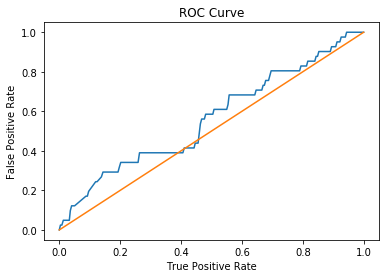

Training set areaUnderROC: 0.5633228120516501


In [12]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.plot(roc['FPR'],roc['FPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

This model is  more stable - with still a postive Gini on the validation set. The Gini is however low. The chart above also shows that the discriminatory power of the model is close to random. It is possible that a better model could be fitted on the full dataset. This shoudl be investigated as a further step. Another further step would be finding additional features which are predictive of cancelation. 